In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import io_utils
import pygad
import os
from tqdm import tqdm
import numpy as np
import sys

In [3]:
data_dir = "../data/"

In [4]:
%%time

df = pd.read_csv(data_dir + "data_unscaled.csv")
df
display(df.head())

df_genes = df.iloc[:, 3:-1]
display(df_genes.head())

,disease,tissue,source,MFI2,RTN4R,TDGF1,RAET1L,RTN4RL1,PRNP,TECTA,...,SLC17A1,OTOP3,PERP,TMEM106A,TMEM184A,ATP6V0A2,ZFYVE27,TMEM114,XKRX,group
0,False,Adipose - Subcutaneous,GTEX,0.655000,0.038000,0.00,0.00,0.664545,9.909545,0.080000,...,0.000,0.0,30.554437,0.078,0.087500,1.266,2.157188,0.0,0.000000,control
1,False,Adipose - Subcutaneous,GTEX,0.283889,0.030000,0.17,0.00,3.287778,6.200000,0.070000,...,0.005,0.0,5.455833,0.410,0.055000,0.860,1.138571,0.0,0.000000,control
2,False,Adipose - Subcutaneous,GTEX,0.778333,0.140000,0.03,0.00,3.610001,7.299998,0.074000,...,0.000,0.0,21.305553,0.485,0.070000,0.980,1.046666,0.0,0.040000,control
3,False,Adipose - Subcutaneous,GTEX,0.180871,0.073333,0.00,0.00,0.772697,5.199000,0.060000,...,0.000,0.0,14.345000,0.350,0.064444,1.100,1.483929,0.0,0.005714,control
4,False,Adipose - Subcutaneous,GTEX,0.420000,0.080000,0.01,0.01,1.196154,7.902500,0.066129,...,0.005,0.0,12.436250,0.360,0.026667,0.840,1.332000,0.0,0.006396,control


,MFI2,RTN4R,TDGF1,RAET1L,RTN4RL1,PRNP,TECTA,BCAN,ALPP,MMP17,...,LPCAT1,SLC17A1,OTOP3,PERP,TMEM106A,TMEM184A,ATP6V0A2,ZFYVE27,TMEM114,XKRX
0,0.655000,0.038000,0.00,0.00,0.664545,9.909545,0.080000,0.000,0.0,0.740000,...,4.268335,0.000,0.0,30.554437,0.078,0.087500,1.266,2.157188,0.0,0.000000
1,0.283889,0.030000,0.17,0.00,3.287778,6.200000,0.070000,0.006,0.0,0.490000,...,3.558557,0.005,0.0,5.455833,0.410,0.055000,0.860,1.138571,0.0,0.000000
2,0.778333,0.140000,0.03,0.00,3.610001,7.299998,0.074000,0.010,0.0,0.210000,...,3.199583,0.000,0.0,21.305553,0.485,0.070000,0.980,1.046666,0.0,0.040000
3,0.180871,0.073333,0.00,0.00,0.772697,5.199000,0.060000,0.010,0.0,0.340000,...,4.098000,0.000,0.0,14.345000,0.350,0.064444,1.100,1.483929,0.0,0.005714
4,0.420000,0.080000,0.01,0.01,1.196154,7.902500,0.066129,0.020,0.0,0.706583,...,4.178571,0.005,0.0,12.436250,0.360,0.026667,0.840,1.332000,0.0,0.006396


Wall time: 13.1 s


In [ ]:
eps = sys.float_info.epsilon

In [6]:
from scoring import Scoring
from plotting import Plotting

S = Scoring(df)
P = Plotting(df, S)

## GA

In [7]:
GENES = np.array(df_genes.columns)

In [8]:
def _fitness_func(solution: [int], idx, key: str, log: bool):
    selected_genes = GENES[solution]
    return S.score(selected_genes, log, key)

In [14]:
def _initial_population(num_genes: int, init_pop_weights):
    sols = []
    for _ in range(sol_per_pop):
        sel = list(init_pop_weights.sample(num_genes, weights=init_pop_weights).index)
        enc = np.isin(genes, sel).nonzero()[0]
        sols.append(enc)
    return sols


def _on_generation(instance, meth, log, run_dir, pbar):
    pbar.update(1)
    if instance.generations_completed % 10 == 0:
        _save_results(instance, meth, log, run_dir)


def _save_best_sols(instance, run_dir):
    best_sols = instance.best_solutions
    if len(best_sols) == 0:
        return
    sols = pd.DataFrame(best_sols).apply(lambda x: GENES[x])
    sols = pd.concat([sols, sols.apply(lambda x: S.score(x, log=log), axis=1)], axis=1)
    instance.best_solutions = []

    path = os.path.join(run_dir, "best_sols.csv")
    if os.path.exists(path):
        sols.to_csv(path, index=False, mode="a", header=False)
    else:
        sols.to_csv(path, index=False)


def _save_results(instance, meth: str, log: bool, run_dir: str):
    _save_best_sols(instance, run_dir)
    instance.plot_fitness().savefig(
        os.path.join(run_dir, "fit_vs_gen.svg"), format="svg"
    )

    solution, solution_fitness, solution_idx = instance.best_solution()
    path = os.path.join(run_dir, f"best_sol_{instance.generations_completed}.svg")
    P.boxplot(GENES[solution], log, path)

    np.save(os.path.join(run_dir, "last_pop"), instance.population)

In [15]:
num_generations = 50
num_parents_mating = 20
# initial_population
sol_per_pop = 500  # inactive if initial_population
gene_type = int

parent_selection_type = "sss"
keep_parents = -1
crossover_type = "scattered"
random_mutation_min_val = 0
mutation_type = "adaptive"
mutation_probability = (0.15, 0.08)
gene_space = range(0, len(GENES))
stop_criteria = ["saturate_10000"]
init_pop_weights = None

In [16]:
def run_and_save_instance(num_genes: int, meth: str, log: bool):
    fitness_func = lambda x, y: _fitness_func(x, y, meth, log)
    run_dir = io_utils.create_run_dir(meth, num_genes)

    with tqdm(total=num_generations) as pbar:
        instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=fitness_func,
            sol_per_pop=sol_per_pop,
            num_genes=num_genes,
            parent_selection_type=parent_selection_type,
            keep_parents=keep_parents,
            mutation_type=mutation_type,
            mutation_probability=mutation_probability,
            gene_space=gene_space,
            gene_type=int,
            allow_duplicate_genes=False,
            on_generation=lambda x: _on_generation(x, meth, log, run_dir, pbar),
            save_best_solutions=True,
            stop_criteria=stop_criteria,
            suppress_warnings=True,
        )

        if init_pop_weights:
            instance.initial_population = _initial_population(
                num_genes, init_pop_weights
            )
        instance.run()

    _save_results(instance, meth, log, run_dir)

  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Evelyn\IdeaProjects\bacarbeit\src\scoring.py:16: RuntimeWarning: divide by zero encountered in log2
  "single_log": lambda h, s: np.log2(s.min()) - np.log2(h.max()),  # TODO +1?
 20%|█████████████████████████▏                                                                                                    | 10/50 [00:15<00:56,  1.42s/it]

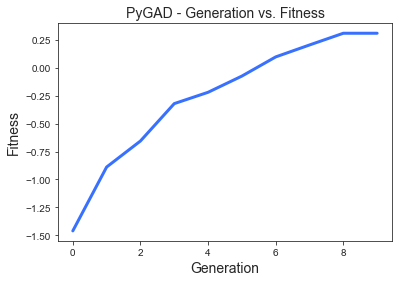

 40%|██████████████████████████████████████████████████▍                                                                           | 20/50 [00:35<00:45,  1.53s/it]

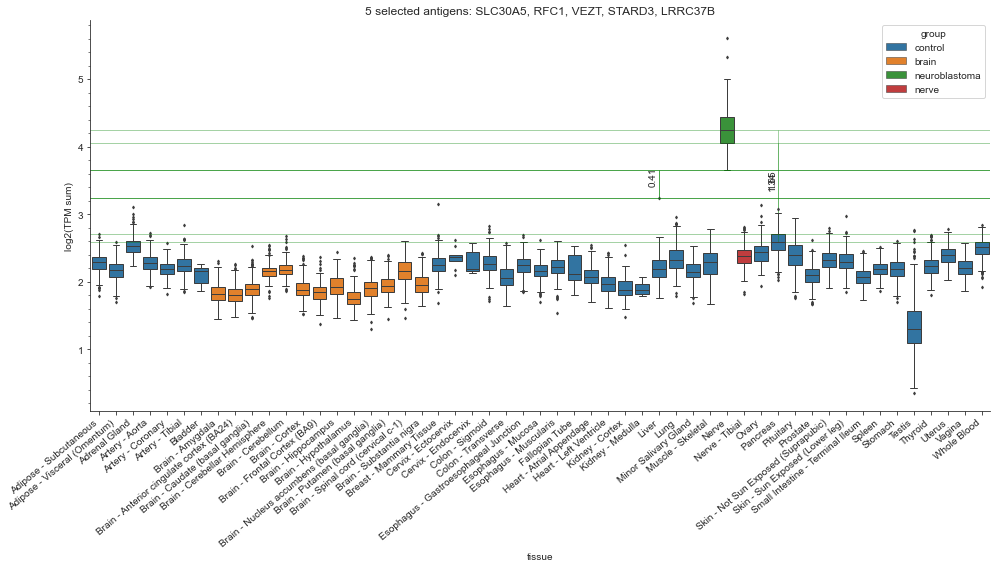

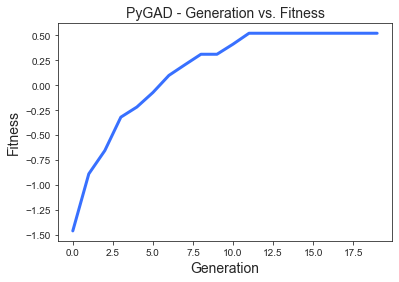

 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 30/50 [00:58<00:31,  1.56s/it]

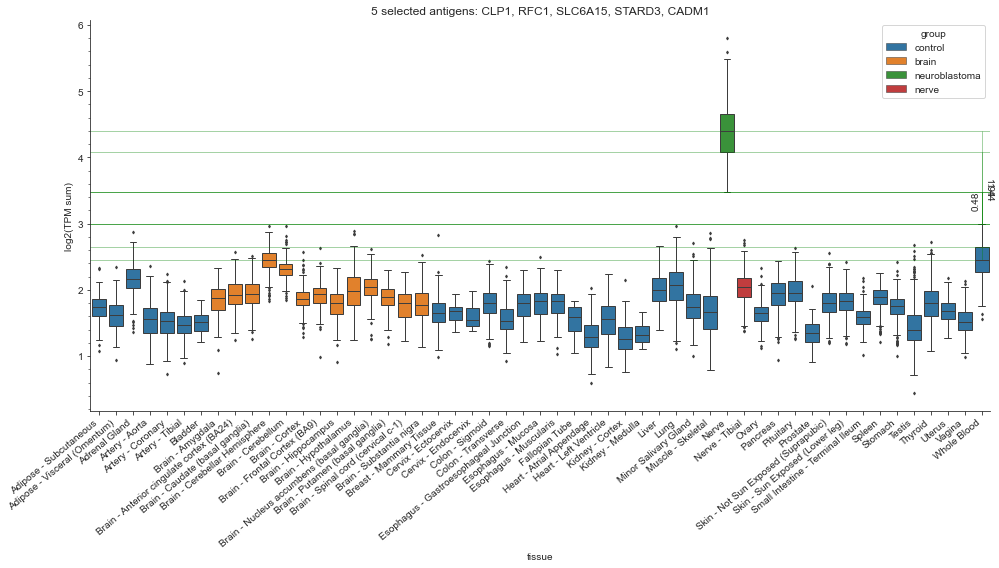

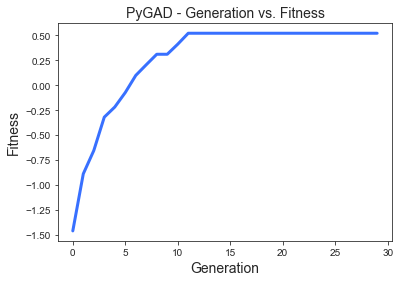

 68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 34/50 [01:17<00:57,  3.59s/it]C:\Users\Evelyn\IdeaProjects\bacarbeit\src\scoring.py:16: RuntimeWarning: divide by zero encountered in log2
  "single_log": lambda h, s: np.log2(s.min()) - np.log2(h.max()),  # TODO +1?
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 40/50 [01:27<00:21,  2.19s/it]


PermissionError: [Errno 13] Permission denied: '..\\runs\\1_single_5\\best_sols.csv'

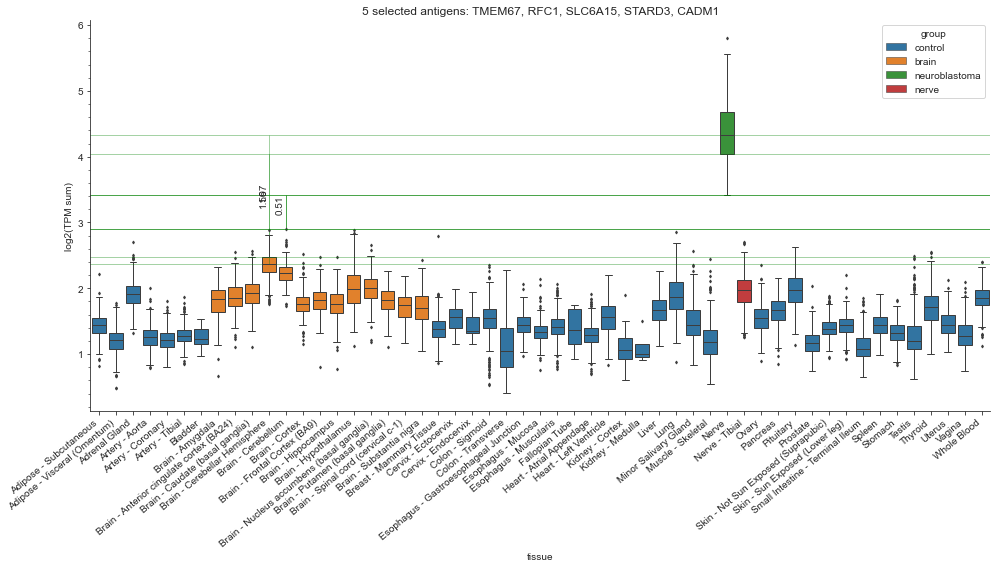

In [18]:
for meth, log in [("single", True)]:
    for num_genes in [5]:
        for rep in range(1):
            run_and_save_instance(num_genes, meth, log)

## ML

In [ ]:
from ml import ML

X = df_genes
y = df["disease"]
ml = ML(42, X, y, Scoring(df))

In [ ]:
n_rep = 20
for n_feat in [5, 10, 20]:
    ml.fit_and_save(n_feat, n_rep)    

## Experimental

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sel = dfs[1].iloc[0, :5].values
data = df[["tissue"] + list(sel)]
data = data.melt(id_vars="tissue")
# data

plt.figure(dpi=120, figsize=(40, 5))

plot = sns.violinplot(
    data=data,
    hue="variable",
    x="tissue",
    y="value",
    linewidth=1,
    flierprops=dict(markersize=1),
    dodge=False,
    inner="point",
)



In [ ]:
%%time
sns.catplot(
    y="value",
    x="variable",
    col="tissue",
    col_wrap=8,
    data=data,
    kind="violin",
    bw=.1,
    cut=0
)

In [ ]:
plot = sns.violinplot(
    data=data[data.tissue == "Nerve"],
    x="variable",
    y="value",
    linewidth=1,
    flierprops=dict(markersize=1),
    dodge=False,
    inner="point",
)

In [ ]:
best_sols = []
for d, n in zip(dfs, [5, 10, 20]):
    s = clean_and_eval([d.head(10)], n)
    best_sols.append(s)
    s.to_csv(f"top10_size{n}.csv")
    s.head(5)["single"]

In [ ]:
best_sols[0]

In [ ]:
vs = best_sols[0].iloc[0, :5].values
scoring.score(vs)
df["s"] = df[vs].sum(axis=1)
n = df[df.tissue == "Nerve"]["s"].min()
h = df[df.tissue != "Nerve"]["s"].max()
n
h
import math

n / h
math.log(n, 2) - math.log(h, 2)

In [ ]:
plotting.boxplot(best_sols[0].iloc[5, :5].values)

In [ ]:
s = df[list(best_sols[0].iloc[0, :5].values)].sum(axis=1)
s = pd.concat([df["tissue"], s], axis=1)
s[s.tissue == "Nerve"].min()
s[s.tissue != "Nerve"].max()

s[s.tissue == "Nerve"].min().values[1] / s[s.tissue != "Nerve"].max().values[1]